In [1]:
import os
import re
from lib_log_parse import load_parsed_logs, parse
from typing import Dict, List, Optional
import numpy as np
from lib_constants import log_no_to_region
from model_publication import Publication
from model_retrieval import Retrieval
import multiprocessing as mp
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
from typing import Tuple

sns.set_theme()

In [2]:
def cdf(series: pd.Series) -> pd.DataFrame:
    return pd.DataFrame.from_dict({
        series.name: np.append(series.sort_values(), series.max()),
        "cdf": np.linspace(0, 1, len(series) + 1)
    })

In [3]:
path = "../data/2023-01-16_gala_nodes"

In [4]:
values = []
for fn in os.listdir(path):
    file_path = os.path.join(path, fn)
    if not os.path.isfile(file_path):
        continue

    if not fn.endswith(".log"):
        continue

    if os.path.exists(file_path + ".p"):
        print(f"Skipping: {file_path}")
        continue

    values += [[file_path]]

with mp.Pool() as pool:
    pool.map(parse, values)

Parsing ../data/2023-01-16_gala_nodes/gala-node-1.log
Resetting retrieval for QmafCkfac1WtffKSxvognP8qqVcv3GSzf38x7uF8trEiJH
Resetting retrieval for Qmcdna6GMLGdvRsR9XQA5jnKCh5vXE5SBE232KBao2aW7u
Resetting retrieval for QmU3ifBQisUYhHebLXsHVG7tQQzPWGZnqynY7BhUPa7xrf
Resetting retrieval for QmVdNT86oUanCAZvH9QKugCSSiWr5fLb9TJQy56MBVvuf2
Resetting retrieval for QmQpHk5UiL4Gfn8FR21qaEpqJQLcbM49oqan17t6MzXwT7
Resetting retrieval for QmWPvkjhFWDg1RDmqjmQR2cnFuWp1pgqowCSbrfUjsdZZe
Resetting retrieval for QmcH7oHmCg5wMvoiZHApNJpeheZe7X2rZ8Yjf8wi58cGay
Resetting retrieval for QmQefrK7kJNEufwXLAcChBf8z6XNWjsRwS2CGb3iPsrBVs
Resetting retrieval for QmXpyjBDUtaZN5aNa3AwLf4SrCRimxkUVXYAkZg6JYR7jN
Resetting retrieval for QmXs7ZoZX7kjPtLBJT5ZhwXuhU2SYLq23J6QBY5uqc59CX
Resetting retrieval for QmYE8sasmMutKMjZcyp6XvMjwhMeReSzCyapYCpv7GNcy4
Resetting retrieval for QmVr8SJbRbQHN8cw3o5W3thvtdfmtoEsD9No1HrzT29pCf
Resetting retrieval for QmW3ojqinJhb7pLKfaojByTvAEVr34H6jpgCsKSA2XGukf
Resetting retrieval for

In [5]:
files = []
for fn in os.listdir(path):
    file_path = os.path.join(path, fn)
    if not os.path.isfile(file_path):
        continue

    if not fn.endswith(".log"):
        continue

    files += [file_path]

pool = mp.Pool(mp.cpu_count())
results = pool.map(load_parsed_logs, list(map(lambda x: [x], files)))


In [6]:
def log_origin(origin: str) -> Optional[int]:
    match = re.search(r".*\/gala-node-(\d).log", origin)
    if match is None:
        return None

    return int(match.group(1))

def region_from_origin(origin: str) -> str:
    node = log_origin(origin)
    return log_no_to_region[node]


results_by_region = {}

for idx, f in enumerate(files):
    region = region_from_origin(f)

    if not region in results_by_region:
        results_by_region[region] = []
    results_by_region[region] += [results[idx][0]]

In [7]:
df_retrievals_dict = {
    "node": [],
    "region": [],
    "started_at": [],
    "overall_retrieval_duration": [],
    "dht_walks_duration": [],
    "find_first_provider_duration": [],
    "content_fetch_duration": [],
    "find_provider_queries_count": [],
    "has_error": [],
}

In [8]:
publications: List[Publication] = []
retrievals: List[Retrieval] = []
for parsed_log in results:
    for log in parsed_log:
        publications += log.publications
        retrievals += log.retrievals

# Remove all retrievals that are marked as invalid
retrievals = list(
    filter(lambda ret: not ret.marked_as_incomplete, retrievals))
retrievals = list(filter(lambda ret: ret.state != Retrieval.State.DONE_WITHOUT_ASKING_PEERS, retrievals))

for ret in retrievals:
    if ret.stream_opened_at is None or ret.connected_at is None:
        print("skip", ret.stream_opened_at, ret.connected_at)
        continue

    node = log_origin(ret.origin)
    region = region_from_origin(ret.origin)
    # region = region_from_origin(ret.origin)
    if region is None:
        raise Exception("AHH")

    df_retrievals_dict["started_at"] += [ret.dial_started_at]
    df_retrievals_dict["node"] += [node]
    df_retrievals_dict["region"] += [region]
    df_retrievals_dict["has_error"] += [ret.done_retrieving_error is not None]

    overall_retrieval_duration = (ret.done_retrieving_at - ret.retrieval_started_at).total_seconds()
    # simulate peer record retrieval by adding the DHT walk duration
    overall_retrieval_duration += ret.get_dht_walk_duration()
    df_retrievals_dict["overall_retrieval_duration"] += [overall_retrieval_duration]

    # simulate peer record retrieval by adding the DHT walk duration
    dht_walks_duration = 2 * ret.get_dht_walk_duration()
    df_retrievals_dict["dht_walks_duration"] += [dht_walks_duration]

    df_retrievals_dict["find_first_provider_duration"] += [(
                                                                   ret.found_first_provider_at - ret.get_providers_queries_started_at).total_seconds()]
    df_retrievals_dict["content_fetch_duration"] += [(ret.done_retrieving_at - ret.dial_started_at).total_seconds()]
    df_retrievals_dict["find_provider_queries_count"] += [
        len(list(filter(lambda gpq: gpq.started_at > ret.done_retrieving_at, ret.get_providers_queries.values())))]

df_retrievals = pd.DataFrame.from_dict(df_retrievals_dict)

skip None 2023-01-16 21:33:22.442178+00:00
skip None 2023-01-18 05:38:55.063671+00:00
skip None 2023-01-21 01:18:53.829067+00:00
skip None 2023-01-17 06:19:01.241034+00:00
skip None 2023-01-18 04:43:30.621306+00:00
skip None 2023-01-18 05:36:15.018519+00:00
skip None 2023-01-19 13:57:59.333363+00:00
skip None 2023-01-17 06:19:00.369913+00:00
skip None 2023-01-18 04:43:29.973701+00:00
skip None 2023-01-19 08:40:57.815826+00:00


In [9]:
len(df_retrievals)

34598

(0.0, 1.8)

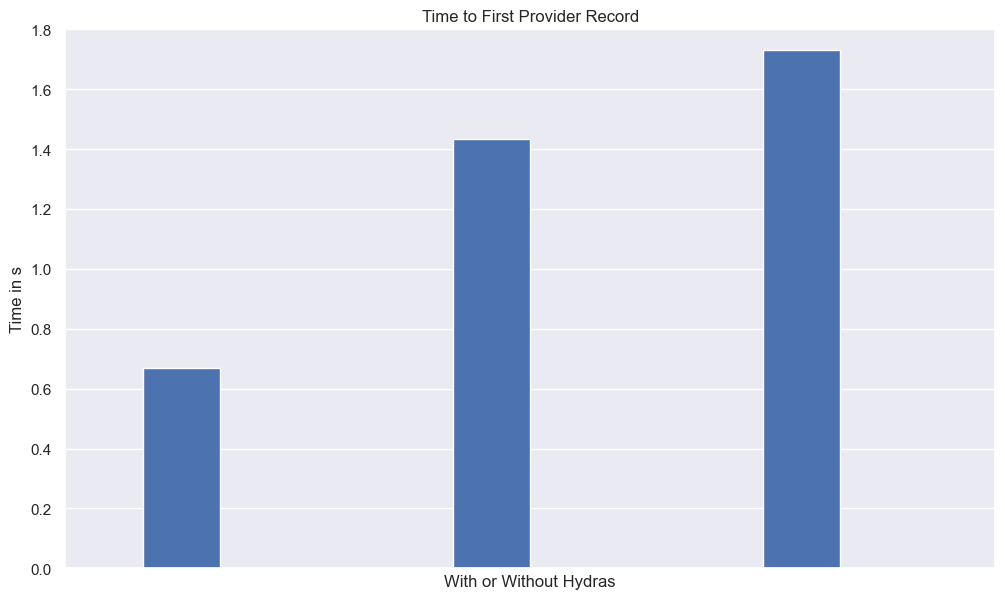

In [10]:
fig, ax = plt.subplots(figsize=[12, 7])

width = 0.25
xticks = []
labels = []
for i, percentile in enumerate([50, 90, 95]):
    with_percentile = np.percentile(df_retrievals["find_first_provider_duration"], percentile)
    ax.bar(i - width / 2, with_percentile, width, label="With Hydras", color="b")

ax.set_title(f"Time to First Provider Record")
ax.set_xlabel("With or Without Hydras")
ax.set_ylabel("Time in s")
ax.set_xticks(xticks, labels)
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(0, 1.8)

/var/folders/5v/11vhc3kx5yxc2kr1whd5hyxc0000gn/T/ipykernel_47492/2253335703.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = grp.quantile([.5, .9, .95])


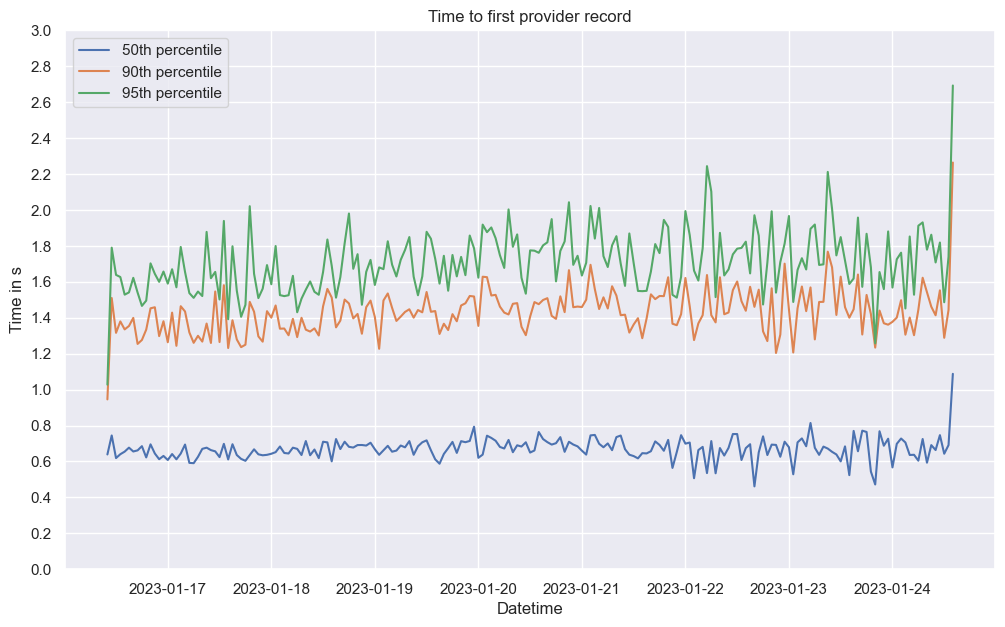

In [13]:
grp = df_retrievals.groupby(by=[df_retrievals.started_at.map(lambda started_at: started_at.replace(minute=0, second=0, microsecond=0))])
grp.find_first_provider_duration.quantile([.5, .9, .95])
df = grp.quantile([.5, .9, .95])
df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=[12, 7])

percentiles = [50, 90, 95]
for percentile in percentiles:
    dat = df[df["level_1"] == percentile / 100]
    ax.plot(dat["started_at"], dat["find_first_provider_duration"], label=f"{percentile}th percentile")

ax.set_ylabel("Time in s")
ax.set_xlabel("Datetime")
ax.set_title("Time to first provider record")
ax.set_ylim(0, 3)
ax.set_yticks(np.arange(0, 3.2, 0.2))
ax.legend()